In [1]:
from pathlib import Path  # for path handling
import pydicom # to read dicom files
import numpy as np  
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # to get a nice progress bar
import os
from matplotlib import patches

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import imgaug
from imgaug.augmentables.bbs import BoundingBox
import imgaug.augmenters as iaa

# Preprocessing

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [3]:
labels = pd.read_csv('../input/heartdetectioninxray/rsna_heart_detection.csv')
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [4]:
ROOT_DIR1 = '../input/rsna-pneumonia-detection-challenge/'
ROOT_DIR2 = '../input/heartdetectioninxray/'

ROOT_PATH = Path(ROOT_DIR1+'stage_2_train_images')
SAVE_PATH = Path(ROOT_DIR2+'Processed')

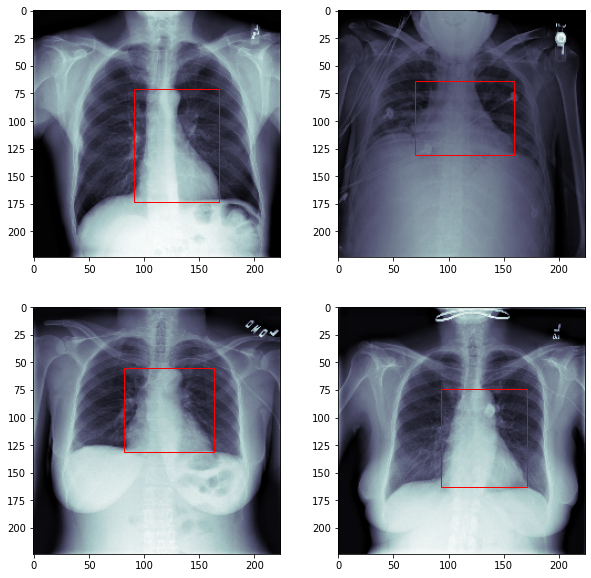

In [5]:
fig, axis = plt.subplots(2,2, figsize=(10,10))

c=0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        
        patientID = data['name']
        dcmPath = ROOT_PATH/str(patientID)
        dcmPath = dcmPath.with_suffix('.dcm')
        
        dcmFile = pydicom.read_file(dcmPath)
        dcmArray = dcmFile.pixel_array
        dcmArray = cv2.resize(dcmArray, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        x = data['x0']
        y = data['y0']
        width = data['w']
        height = data['h']
        
        axis[i][j].imshow(dcmArray, cmap = 'bone')
        rect = patches.Rectangle((x,y), width, height, linewidth=1, edgecolor="r", facecolor='none')
        axis[i][j].add_patch(rect)
        
        c+=1

In [6]:
sums, sums_squared = 0, 0 

train_ids = []
val_ids = []

for counter, patientID in enumerate(list(labels.name)):
    dcmPath = ROOT_PATH/str(patientID)
    dcmPath = dcmPath.with_suffix('.dcm')
        
    dcmFile = pydicom.read_file(dcmPath)
    dcmArray = dcmFile.pixel_array
    dcmArray = cv2.resize(dcmArray, (IMAGE_WIDTH,IMAGE_HEIGHT))
    dcmArray = (dcmArray/255).astype(np.float16)
    
    train_or_val = "train" if counter < 400 else 'val'
    
    if train_or_val =="train":
        train_ids.append(patientID)
    else:
        val_ids.append(patientID)
        
    current_save_path = Path(f"./{train_or_val}")
    # create directory if not exist
    current_save_path.mkdir(parents = True, exist_ok = True)
    
    np.save(current_save_path/patientID, dcmArray)
    
    normalizer = IMAGE_WIDTH*IMAGE_HEIGHT
    
    if train_or_val == "train":
        sums += np.sum(dcmArray) / normalizer
        sums_squared += (dcmArray**2).sum() / normalizer
    

In [7]:
# saving train and text ids to later be used for augumentation and other stuff
np.save(Path("./train_subjects"), train_ids)
np.save(Path("./val_subjects"), val_ids)

In [8]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared/len(train_ids)) - (mean**2)) # standard deviation

mean, std

(0.49430165816326493, 0.2527964897943661)

# Augumenting Data

In [9]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        # Extract the patiendID (the filename)
        patientId = data["name"].item()
        
        # Get entries of given patient
        # Extract coordinates
        bbox = []

        x_min = data["x0"].item()
        bbox.append(x_min)
        y_min = data["y0"].item()
        bbox.append(y_min)
        x_max = x_min + data["w"].item()  # get xmax from width
        bbox.append(x_max)
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox.append(y_max)


        # Load file and convert to float32
        file_path = self.root_path/str(patientId)  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            random_seed = torch.randint(0, 1000000, (1,))[0].item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - mean) / std

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox


In [10]:
# cerating augumentation pipeline

seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
        scale = (0.8,1.2),
        rotate = (-10,10),
        translate_px = (-10,10),
    ),
])

In [11]:
labels_csv_path = "../input/heartdetectioninxray/rsna_heart_detection.csv"
patients_path = "./train_subjects.npy"
train_root = "./train/"

In [12]:
dataset = CardiacDataset(labels_csv_path, patients_path, train_root, seq)

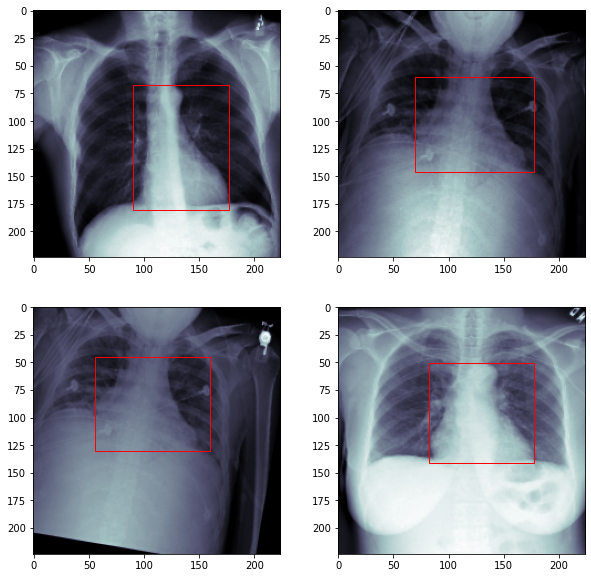

In [13]:
fig, axis = plt.subplots(2,2, figsize=(10,10))

for i in range(2):
    for j in range(2):
        img, bbox = dataset[i+j]
        axis[i][j].imshow(img[0], cmap='bone')
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor='none')
        axis[i][j].add_patch(rect)

# Training the object detector

In [14]:
BATCH_SIZE = 8
NUM_WORKERS = 4

In [15]:
train_dataset = CardiacDataset("../input/heartdetectioninxray/rsna_heart_detection.csv", 
                               "./train_subjects.npy", "./train/", seq)

val_dataset = CardiacDataset("../input/heartdetectioninxray/rsna_heart_detection.csv", 
                               "./val_subjects.npy", "./val/", None) 

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, num_workers=NUM_WORKERS, shuffle = False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Since we want bounding box as an output, the number of outputs should be 4(a value for each corner of the box)
**Also we desire to get continuous values as the predictions(and not probability of some class like in case of classic 
classification, therefore we'll user L2 loss or Mean squared error will be used, instead of the cross entropy**

In [18]:
class HeartDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        
        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            # Extract the coordinates from the prediction           
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            
            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [19]:
model = HeartDetectionModel()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [21]:
gpus = 1
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                     default_root_dir="./weights", callbacks=checkpoint_callback,
                     max_epochs=100)

In [22]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluation

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
preds = []
labels = []
model.to(device)
with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

In [24]:
# Compute mean deviation between prediction and labels for each coordinate
abs(preds-labels).mean(0)

tensor([ 8.0713,  7.6457, 14.6773, 14.2259])

tensor([ 85,  52, 174, 126])


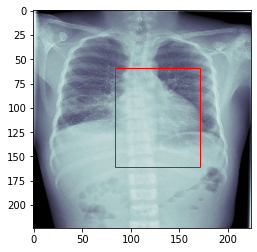

In [25]:
IDX = 60  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)